## Problem 4
___

In this section, we train and validate our models on the Penn Treebank dataset. Since the Natural Language Processing task that consists in sentence generation is not a typical classification task, we use Perplexity rather than Cross-entropy as a loss function:

$$
\mbox{PPL}= \mbox{exp}(\frac{1}{TN}\sum_{t=1}^T \sum_{n=1}^N -\mbox{log}P(\textbf{x}_1^{(n)}|\textbf{x}_t^{(n)},...,\textbf{x}_{t-1}^{(n)}))
$$

where $t$ is the position in the sequence, and $n$ is the index of the sequence.

We then explore how two different optimizers perform for each model compared to vanilla Stochastic Gradient Descent.

Finally, we explore how hyperparameters influence each model and search for the best hyperparameter combinations.

This notebook is designed to be executed on Google Colab. The folder first needs to be virtually mounted by adapting and executing the following commands:

In [0]:
# Mount the virtual drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# rootpath must be changed to your virtual relative path to the root "Final" folder

rootpath="gdrive/My Drive/Colab Notebooks/AaronTP2/Khalifa_latest/Final"
savepath=rootpath+"/Figures/"

For convenience, we have modded the ptb-lm.py script so it prints a progress bar, is able to perform a random search, implements early stopping, and allows us to tune more hyperparameters.

The randomSearch.py script can be found in our repository. It can be used exactly like the ptb-lm.py script.

Most experiments can be launched with the ptb-lm.py script, except the ones with additional hyperparameters (4.3 Transformer).

### Summary:
___

[Question 1](#4.1)  
[Question 2](#4.2)  
[Question 3](#4.3) 

___
### 0. Helper functions
___
This section defines helper functions ans classes that will be used later in our answers.

In [0]:
# ExperimentArgs is used to load the results saved by the ptb-lm.py script
# and by our mods of ptb-lm.py

class ExperimentArgs:
    def __init__(self, path):
        base = path
        for file in os.listdir(base):
            if "exp_config" in file:
                with open(os.path.join(base,file),"r") as f:
                    for line in f:
                        a,b = line.strip().split("    ")
                        if a in ["dp_keep_prob","initial_lr"]:
                            setattr(self,a,float(b))
                        else:
                            setattr(self,a,int(b) if b.isdigit() else b)
            if "log" in file:
                setattr(self,"times",[])
                with open(os.path.join(base,file),"r") as f:
                    for i,line in enumerate(f):
                        e,d = line.strip().split("in epoch: ")
                        if i>0:
                            tmp = self.times[-1]
                            self.times.append(float(d)+ tmp)
                        else:
                            self.times.append(float(d))

In [0]:
# multiplot() is used to plot all the results curves in a target folder.
# The target folder must contain only subfolders outputed by ptb-lm.py
# or its mods.

from glob import glob
import os
import pathlib
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def multiplot(folder_path, figsize=(15,5), clock_time=False, separate=True, title="", ylim=1000, print_args=False, annotate=True):
  '''
  Plots the curves of the subfolders of folder_path
  If separate=True:
    Plots all ppls and losses separately
  Else:
    Plots all ppls on the same graph on the same figure
  '''
  l = glob(os.path.join(path, '*')) # find all the subfolders in path
  l = sorted(l, key= lambda x: pathlib.PurePath(x).name) # sort alphabetically
  nb_curves = len(l)
  #print("Found ", nb_curves, " subfolders")
  if not separate: # joint plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(title)
    ax1.set_ylim(top=ylim)
    ax2.set_ylim(top=ylim)
    ax1.set_ylabel('PPL')
    ax2.set_ylabel('PPL')
    if clock_time:
      ax1.set_xlabel('clock time (s)')
      ax2.set_xlabel('clock time (s)')
    else:
      ax1.set_xlabel('epoch')
      ax2.set_xlabel('epoch')
  for i, p in enumerate(l): # for each subfolder
    pp = pathlib.PurePath(p)
    ppn = pp.name
    curvesdict = np.load(os.path.join(p,'learning_curves.npy'))[()] # four curves in a dict
    ea = ExperimentArgs(p)
    namefig = f"{ea.model} {ea.optimizer} {ea.initial_lr}lr - {ea.num_layers}layers{ea.hidden_size}, {ea.batch_size}batchSize, embSize{ea.emb_size}, {ea.dp_keep_prob}keepProb, {ea.seq_len}seqLen, {ea.num_epochs}epochs"
    if 'n_heads' in dir(ea): # for transformer
      namefig = f"{namefig}, {ea.n_heads}heads"
    if 'patience' in dir(ea): # not all our experiments use early stopping
      namefig = f"{namefig}, {ea.patience}patience"
    if separate:
      plt.figure(figsize=figsize)
      plt.suptitle(namefig)
    elif print_args: # print the args for joint plot
      print("Curve ", i, ": ", namefig)
    for col, (label, data) in enumerate(curvesdict.items()):
      if separate:
        if label == 'train_ppls':
          col = col+1
          ax = plt.subplot(1, 3, 1)
          if(clock_time):
            plt.plot(ea.times, data, label=label)
          else:
            plt.plot(data, label=label)
        elif label == 'val_ppls':
          bestEpoch = np.argmin(data)
          if(clock_time):
            plt.plot(ea.times, data, label=label)
            plt.plot(ea.times[bestEpoch], data[bestEpoch], "ro", label=f'best_val:{data[bestEpoch]:.2f}')
            plt.xlabel('clock time (s)')
          else:
            plt.plot(data, label=label)
            plt.plot(bestEpoch, data[bestEpoch], "ro", label=f'best_val:{data[bestEpoch]:.2f}')
            plt.xlabel('epoch')
          plt.legend(loc='upper right')
        else:
          plt.subplot(1, 3, col)
          plt.plot(data, label=label)
          plt.xlabel('step')
          plt.legend(loc='upper right')
          
      else: # not separate
        if label == 'train_ppls':
          if(clock_time):
            ax1.plot(ea.times, data, label=label+str(i))
          else:
            ax1.plot(data, label=label+str(i))
          ax1.legend(loc='upper right')
        elif label == 'val_ppls':
          bestEpoch = np.argmin(data)
          if(clock_time):
            ax2.plot(ea.times, data, label=f'{label}{i}:{data[bestEpoch]:.2f}')
            ax2.plot(ea.times[bestEpoch], data[bestEpoch], "ro")
            if annotate:
              ax2.annotate(f'{data[bestEpoch]:.2f}', (ea.times[bestEpoch],data[bestEpoch]))
          else:
            ax2.plot(data, label=f'{label}{i}:{data[bestEpoch]:.2f}')
            ax2.plot(bestEpoch, data[bestEpoch], "ro")
            if annotate:
              ax2.annotate(f'{data[bestEpoch]:.2f}', (bestEpoch,data[bestEpoch]))
          ax2.legend(loc='upper right')

### 1. Model Comparison <a id='4.1'></a>
___
In this part, we compare the three architectures with the hyperparameters given in the ptb-lm.py script.

In [0]:
path=rootpath+"/4_1"

The commands we have executed to compute these architectures are:

In [0]:
!python ptb-lm.py --model=RNN --optimizer=ADAM --initial_lr=0.0001 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35 --save_best
!python ptb-lm.py --model=GRU --optimizer=SGD_LR_SCHEDULE --initial_lr=10 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35 --save_best
!python ptb-lm.py --model=TRANSFORMER --optimizer=SGD_LR_SCHEDULE --initial_lr=20 --batch_size=128 --seq_len=35 --hidden_size=512 --num_layers=6 --dp_keep_prob=0.9 --save_best

### Per epochs

We first compare how the three models perform over training with respect to the number of training epochs.

Curve  0 :  GRU SGD_LR_SCHEDULE 10.0lr - 2layers1500, 20batchSize, embSize200, 0.35keepProb, 35seqLen, 40epochs
Curve  1 :  RNN ADAM 0.0001lr - 2layers1500, 20batchSize, embSize200, 0.35keepProb, 35seqLen, 40epochs
Curve  2 :  TRANSFORMER SGD_LR_SCHEDULE 20.0lr - 6layers512, 128batchSize, embSize200, 0.9keepProb, 35seqLen, 40epochs


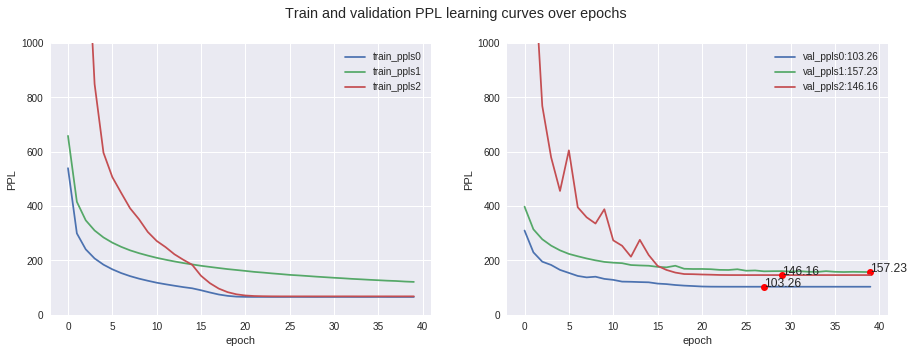

In [0]:
multiplot(path, clock_time=False, separate=False, print_args=True, title="Train and validation PPL learning curves over epochs")

Each curve number corresponds to the printed hyperparameters. For instance, Curve 0 (GRU) corresponds to train_ppls0 and val_ppls0 (blue curve).

The red dots indicate the best validation perplexity over training. The best validation losses are given in the legend.

With these hyperparameters, all three models converge in roughly the same number of epochs. We also notice that the Gated Recurent Unit model (in blue) outperforms by far both Transformer and Vanilla Recurent Network in this setting.

### Per Wall Clock Time
The number of training epochs is not representative of the actual duration of training. Let us now compare how the three models perform over training with respect to the real wall-clock time.

Curve  0 :  GRU SGD_LR_SCHEDULE 10.0lr - 2layers1500, 20batchSize, embSize200, 0.35keepProb, 35seqLen, 40epochs
Curve  1 :  RNN ADAM 0.0001lr - 2layers1500, 20batchSize, embSize200, 0.35keepProb, 35seqLen, 40epochs
Curve  2 :  TRANSFORMER SGD_LR_SCHEDULE 20.0lr - 6layers512, 128batchSize, embSize200, 0.9keepProb, 35seqLen, 40epochs


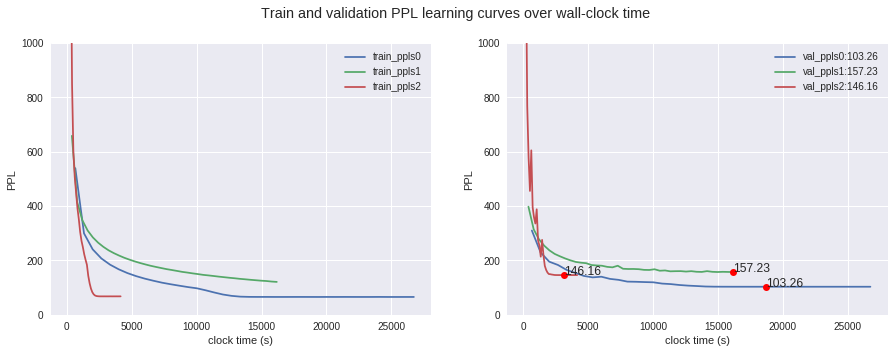

In [0]:
multiplot(path, clock_time=True, separate=False, print_args=True, title="Train and validation PPL learning curves over wall-clock time")

Although the three models roughly converge in the same number of epochs, the actual wall-clock time of convergence is very different. Indeed, although all three models are trained for 40 epochs in this experiment, we see here that the GRU takes longer to train than the two other models, whereas the Transformer is by far the fastest to train.

Concerning GRU, it has indeed more parameters to train than the vanilla RNN, since we have six matrices of equal size to train for each hidden layer of the GRU: $W_r$, $W_z$, $W_h$ and $U_r$, $U_z$, $U_h$, whereas we only have two for each hidden layer of the vanilla RNN: $W$ and $U$.

Concerning the Transformer, the dramatical improve of training speed is due to the fact that the Transformer does not have any recurrent units, which means that it has much less sequential opearations to execute. Since we use a GPU to train our models, most computations can therefore be parallelized, which results in a much faster training.

### 2. Exploration of optimizers <a id='1.2'></a>
___
In this part, we compare different optimizers for the three models.

The commands we have executed to compute these architectures are:

In [0]:
!python ptb-lm.py --model=RNN --optimizer=SGD --initial_lr=0.0001 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35 
!python ptb-lm.py --model=GRU --optimizer=SGD --initial_lr=10 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35
!python ptb-lm.py --model=TRANSFORMER --optimizer=SGD --initial_lr=20 --batch_size=128 --seq_len=35 --hidden_size=512 --num_layers=6 --dp_keep_prob=.9
!python ptb-lm.py --model=RNN --optimizer=SGD_LR_SCHEDULE --initial_lr=1 --batch_size=20 --seq_len=35 --hidden_size=512 --num_layers=2 --dp_keep_prob=0.35
!python ptb-lm.py --model=GRU --optimizer=ADAM --initial_lr=0.0001 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35
!python ptb-lm.py --model=TRANSFORMER --optimizer=ADAM --initial_lr=0.001 --batch_size=128 --seq_len=35 --hidden_size=512 --num_layers=2 --dp_keep_prob=.9

### For RNN

Curve  0 :  RNN SGD_LR_SCHEDULE 1.0lr - 2layers512, 20batchSize, embSize200, 0.35keepProb, 35seqLen, 40epochs
Curve  1 :  RNN SGD 0.0001lr - 2layers1500, 20batchSize, embSize200, 0.35keepProb, 35seqLen, 40epochs


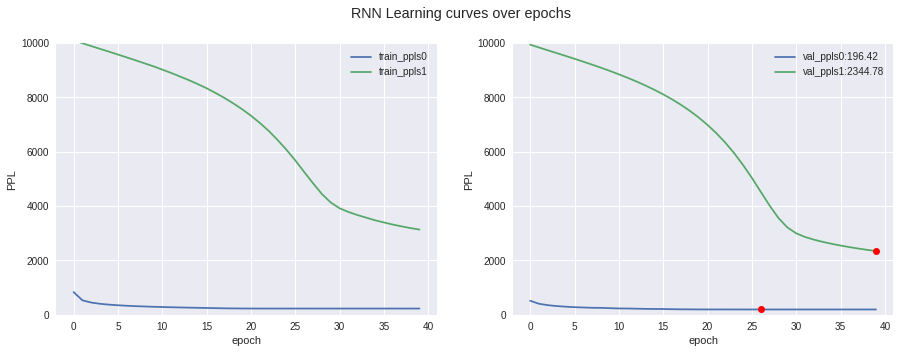

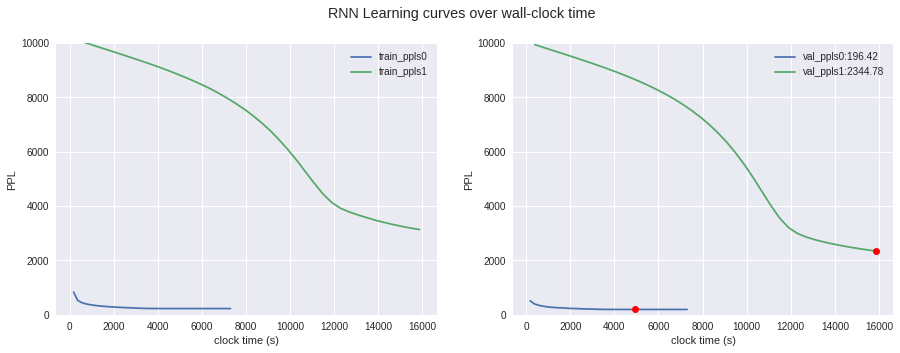

In [0]:
path=rootpath+"/4_2/RNN"

multiplot(path, clock_time=False, separate=False, print_args=True, annotate=False, ylim=10000, title="RNN Learning curves over epochs")
multiplot(path, clock_time=True, separate=False, print_args=False, annotate=False, ylim=10000, title="RNN Learning curves over wall-clock time")

The fact that we use very different initial learning rates keeps us from really comparing vanilla SGD and learning rate decay here. Although we decay the learning rate after each epoch, it will take ages before we go from 1.0 to 0.0001 with a decay of $\frac{1}{1.15}$ (plus, the learning rate decay - blue curve - starts at eopch 15).

### For GRU:

Curve  0 :  GRU ADAM 0.0001lr - 2layers1500, 20batchSize, embSize200, 0.35keepProb, 35seqLen, 40epochs
Curve  1 :  GRU SGD 10.0lr - 2layers1500, 20batchSize, embSize200, 0.35keepProb, 35seqLen, 40epochs


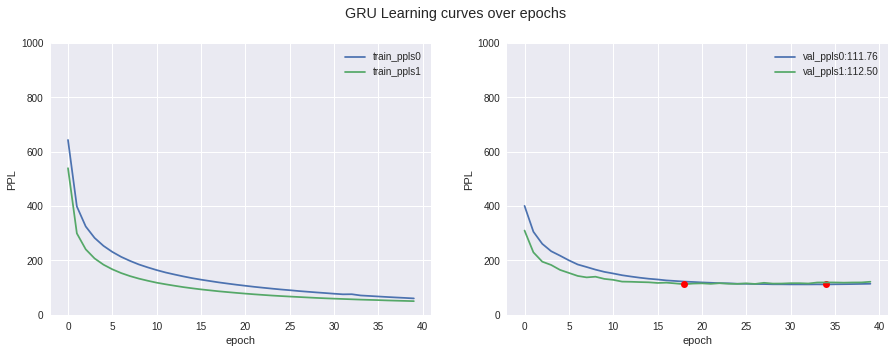

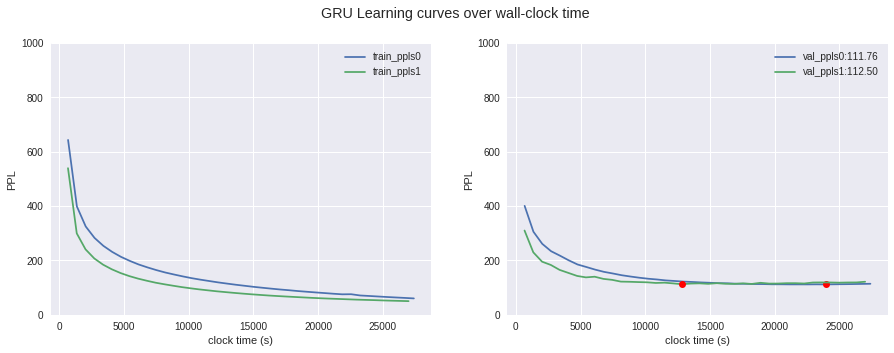

In [0]:
path=rootpath+"/4_2/GRU"

multiplot(path, clock_time=False, separate=False, print_args=True, annotate=False, title="GRU Learning curves over epochs")
multiplot(path, clock_time=True, separate=False, print_args=False, annotate=False, title="GRU Learning curves over wall-clock time")

Although we also use very different initial learning rates, Adam and SGD converge roughly at the same speed. Indeed, Adam is an accelerated method that uses the cumulated gradients over time. It uses a momentum strategy to descend the loss function landscape, similarly to a ball descending a 3 dimensional landscape. Whereas SGD will move at constant speed where the gradients are constant, Adam will keep accelerating along the slope.

### For Transformer:

Curve  0 :  TRANSFORMER ADAM 0.001lr - 2layers512, 128batchSize, embSize200, 0.9keepProb, 35seqLen, 40epochs
Curve  1 :  TRANSFORMER SGD 20.0lr - 6layers512, 128batchSize, embSize200, 0.9keepProb, 35seqLen, 40epochs


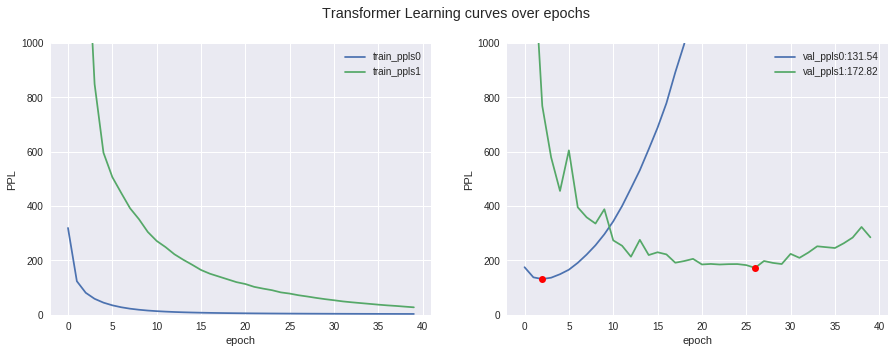

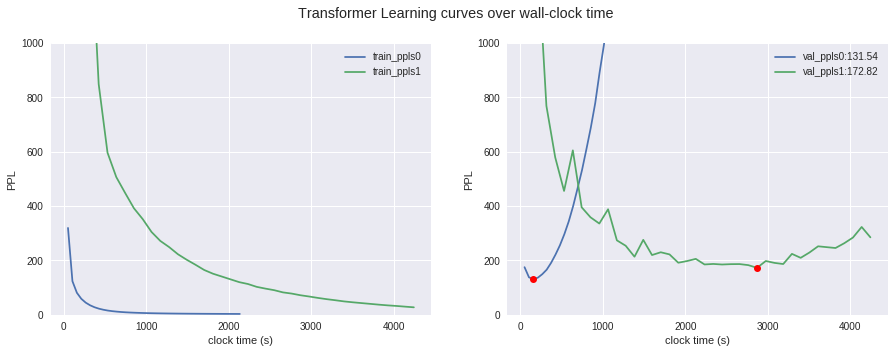

In [0]:
path=rootpath+"/4_2/Transformer"

multiplot(path, clock_time=False, separate=False, print_args=True, annotate=False, title="Transformer Learning curves over epochs")
multiplot(path, clock_time=True, separate=False, print_args=False, annotate=False, title="Transformer Learning curves over wall-clock time")

Whereas the Transformer converges quite slowly with SGD and a big learning rate, it is extremely quick to converge with Adam and a small initial learning rate, and it quickly starts overfitting. This is again linked to the fact that Adam is an accelerated method.

### 3. Exploration of hyperparmeters <a id='1.3'></a>
___
In this part, we explore different hyperparameters settings for each architecture.

### For RNN

The results of this section have been found using the ptb-lm.py script with no additional hyperparameters.

The models have been trained on a slower personnal GPU, which is why the convergence speed with respect to wall-clock time does not compare to the results we got for GRU and Transformer on Google Colab.

Curve  0 :  RNN ADAM 0.0001lr - 3layers1000, 20batchSize, embSize200, 0.5keepProb, 35seqLen, 40epochs
Curve  1 :  RNN ADAM 0.0001lr - 2layers2000, 20batchSize, embSize200, 0.3keepProb, 35seqLen, 40epochs
Curve  2 :  RNN ADAM 0.0001lr - 2layers2000, 20batchSize, embSize200, 0.6keepProb, 35seqLen, 40epochs
Curve  3 :  RNN ADAM 0.0001lr - 2layers1500, 32batchSize, embSize200, 0.35keepProb, 50seqLen, 40epochs
Curve  4 :  RNN ADAM 0.001lr - 2layers1500, 20batchSize, embSize200, 0.35keepProb, 35seqLen, 40epochs
Curve  5 :  RNN SGD_LR_SCHEDULE 0.5lr - 2layers1500, 20batchSize, embSize200, 0.5keepProb, 35seqLen, 40epochs
Curve  6 :  RNN SGD_LR_SCHEDULE 1.0lr - 2layers1500, 20batchSize, embSize200, 0.35keepProb, 35seqLen, 40epochs


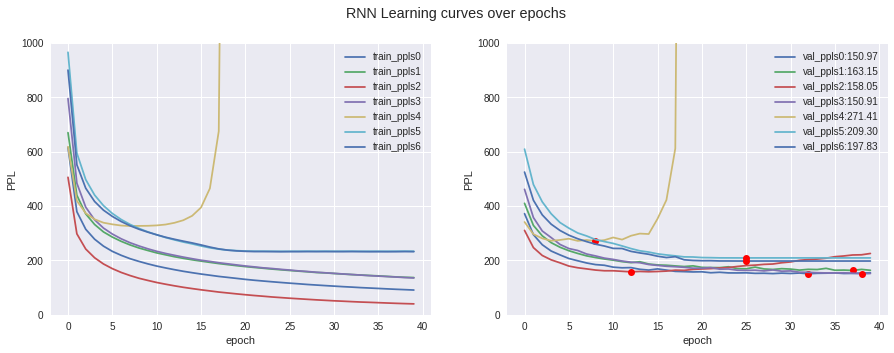

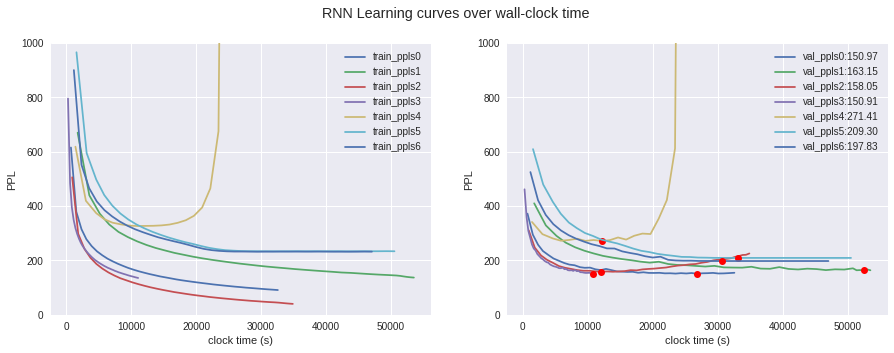

In [0]:
path=rootpath+"/4_3/RNN2/run_at_the_same_time"

multiplot(path, clock_time=False, separate=False, print_args=True, annotate=False, title="RNN Learning curves over epochs")
multiplot(path, clock_time=True, separate=False, print_args=False, annotate=False, title="RNN Learning curves over wall-clock time")

For the RNN architecture, we quickly found that the Adam optimizer gives the best results in terms of both optimal validation loss and convergence speed.

The best hyperparameters we found here are described those of curves $0$ and $3$, for which we have achieved better validation losses than the best previous RNN model, given in question 4.1 $(150.9 < 157.2)$

- Curve 0: The strategy used to improve the validation perplexity was to add a third layer here. Adding depht however required to use a lower dropout probability as the effect of dropout add up at each layer. Also, using more depht allowed for a more narrow width $(1000 < 1500)$.

- Curve 1: The performance achieved here is explained by the augmentation of the sequence length up to $50$ and augmenting batch size. Although it is unlikely that our vanilla RNN is able to propagate effective gradients up to 50 words, it might still be enough to explain the better performance of our model.

We also notice that a higher initial learning rate with adam leads to an explosion here (and not overfitting, since the the loss over the training set also explodes). This might be explained by exploding gradients, although the Adam optimizer is supposed to mitigate this effect.

In [0]:
path=rootpath+"/4_3/RNN2/run_at_the_same_time"

multiplot(path, clock_time=False, separate=False, print_args=True, annotate=False, title="RNN Learning curves over epochs")
multiplot(path, clock_time=True, separate=False, print_args=False, annotate=False, title="RNN Learning curves over wall-clock time")

### For GRU

The results of this section have been found using the ptb-lm.py script with no additional hyperparameters.



The first experiment we have done with the GRU architecture was to  make it deeper and narrower.

Curve  0 :  GRU ADAM 0.0001lr - 5layers200, 200batchSize, embSize200, 0.3keepProb, 30seqLen, 40epochs
Curve  1 :  GRU ADAM 0.001lr - 5layers200, 200batchSize, embSize200, 0.3keepProb, 30seqLen, 40epochs
Curve  2 :  GRU ADAM 0.001lr - 10layers100, 200batchSize, embSize100, 0.4keepProb, 50seqLen, 100epochs


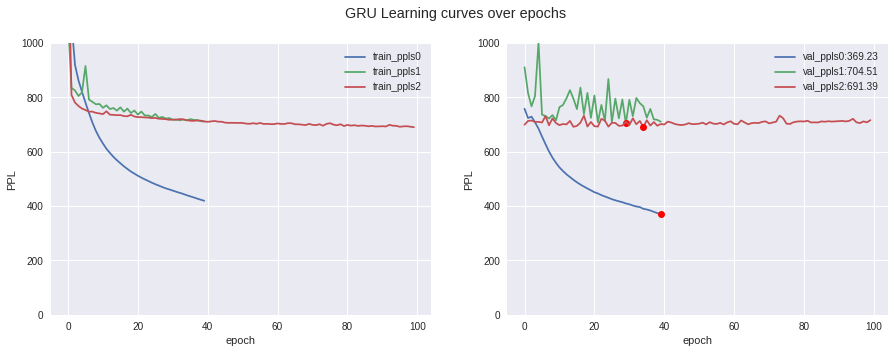

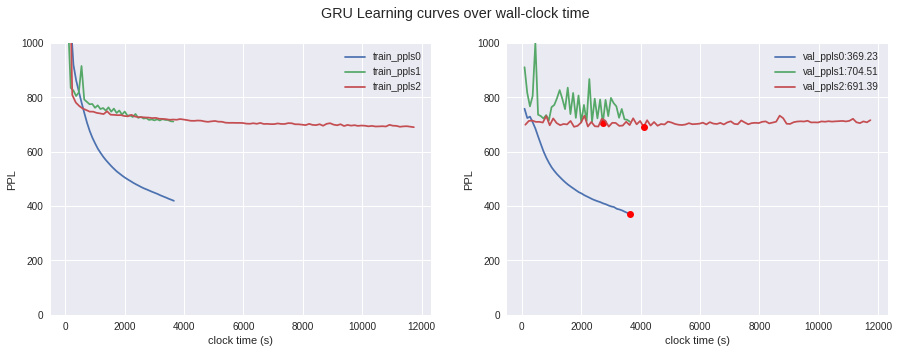

In [0]:
path=rootpath+"/4_3/GRU/Failures"

multiplot(path, clock_time=False, separate=False, print_args=True, annotate=False, title="GRU Learning curves over epochs")
multiplot(path, clock_time=True, separate=False, print_args=False, annotate=False, title="GRU Learning curves over wall-clock time")

We plot these results because we believe they highlight the fact that Adam with a too big initial learning rate does not compensate the overshooting effect over time as we first expected. In practice, one should start with a small learning rate and leave to the momentum effect of Adam to guide the gradient descent. Also, the curve $0$ (in blue) shows that the depht of the model makes the training time very long, even if we narrow the hidden layers.

We then tried more shallow models, with smaller initial learning rates for Adam optimizer, and compared them to other models trained with the learning decay optimizer.

Curve  0 :  GRU ADAM 0.0001lr - 4layers400, 100batchSize, embSize200, 0.7keepProb, 50seqLen, 40epochs
Curve  1 :  GRU ADAM 0.0005lr - 2layers800, 100batchSize, embSize100, 0.3keepProb, 50seqLen, 40epochs
Curve  2 :  GRU SGD_LR_SCHEDULE 10.0lr - 3layers1000, 100batchSize, embSize150, 0.5keepProb, 50seqLen, 40epochs
Curve  3 :  GRU SGD_LR_SCHEDULE 10.0lr - 2layers1000, 20batchSize, embSize100, 0.35keepProb, 20seqLen, 40epochs


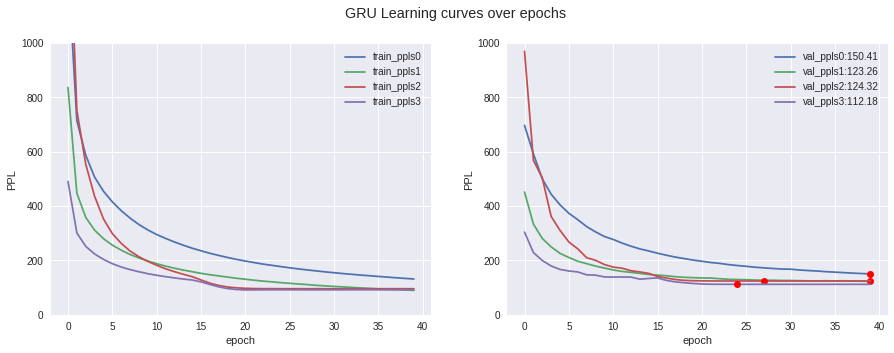

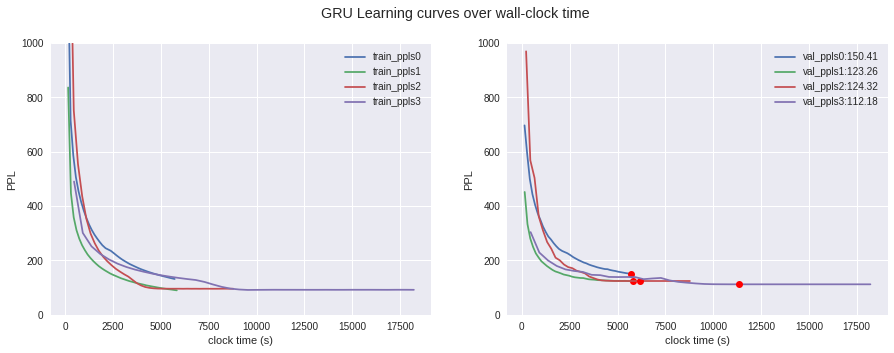

In [0]:
path=rootpath+"/4_3/GRU/Good"

multiplot(path, clock_time=False, separate=False, print_args=True, annotate=False, title="GRU Learning curves over epochs")
multiplot(path, clock_time=True, separate=False, print_args=False, annotate=False, title="GRU Learning curves over wall-clock time")

The learning rate decay and the Adam optimizer lead to similar performances here. Since the GRU is the longest to train and we don't have access to better computational ressources than Google Colab, we could not train more GRU models and did not find a better hyperparameter setting than the reference model given in question 4.2.

### For Transformer

Since the transformer is very fast to train compared to the two other architectures, we could do many experiments to fine-tune our model. We have modded the ptb-lm.py script for this matter, and implemented a random search algorithm to help us find the best hyperparameters. To make this search quicker, we have also implemented early stopping in this script, introducing the patience hyperparameter.

This modded script is given in the repository. It is used as the original ptb-lm.py, but the omitted parameters are randomized instead of being set to default.

One example of use case is the following:

In [0]:
!python randomSearch.py --model=TRANSFORMER --save_best --nb_searches=20

First, we executed a broad random search to get a feeling of which hyperparameters work well with the transformer. The results were the following:

Curve  0 :  TRANSFORMER ADAM 0.001lr - 8layers1024, 128batchSize, embSize50, 0.35keepProb, 10seqLen, 20epochs, 32heads, 2patience
Curve  1 :  TRANSFORMER ADAM 0.0005lr - 8layers256, 128batchSize, embSize200, 0.9keepProb, 20seqLen, 10epochs, 16heads, 2patience
Curve  2 :  TRANSFORMER SGD_LR_SCHEDULE 20.0lr - 8layers512, 128batchSize, embSize200, 0.1keepProb, 30seqLen, 20epochs, 16heads, 5patience
Curve  3 :  TRANSFORMER SGD_LR_SCHEDULE 10.0lr - 4layers1024, 64batchSize, embSize50, 0.35keepProb, 50seqLen, 10epochs, 32heads, 2patience
Curve  4 :  TRANSFORMER SGD_LR_SCHEDULE 10.0lr - 6layers256, 128batchSize, embSize200, 0.9keepProb, 40seqLen, 40epochs, 16heads, 5patience
Curve  5 :  TRANSFORMER SGD_LR_SCHEDULE 30.0lr - 8layers1024, 64batchSize, embSize50, 0.1keepProb, 50seqLen, 10epochs, 8heads, 5patience
Curve  6 :  TRANSFORMER SGD_LR_SCHEDULE 10.0lr - 4layers1024, 128batchSize, embSize300, 0.1keepProb, 10seqLen, 20epochs, 16heads, 3patience
Curve  7 :  TRANSFORMER SGD_LR_SCHEDULE 30.0lr

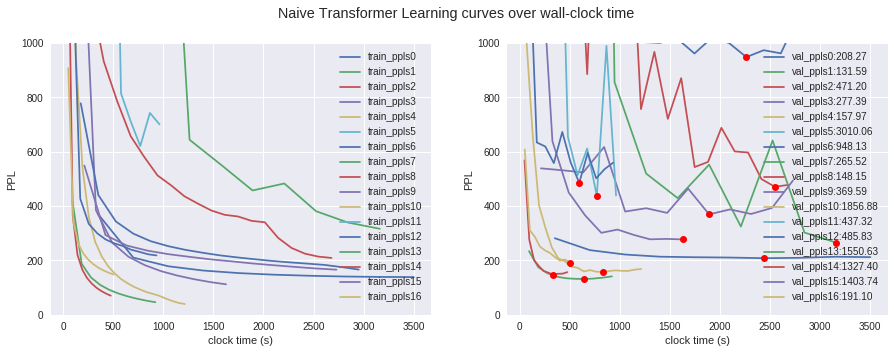

In [0]:
path=rootpath+"/4_3/Transformer/Sauvegarde results"

multiplot(path, clock_time=True, separate=False, print_args=True, annotate=False, title="Naive Transformer Learning curves over wall-clock time")

Analysing these results, it seems overally clear that Adam and learning decay perform better than vanilla SGD with transformer too. Also, a lower dropout probability seems to make for a better model. We therefore performed another large random search only with Adam and learning rate decay:

Curve  0 :  TRANSFORMER ADAM 0.0001lr - 3layers64, 128batchSize, embSize500, 1.0keepProb, 30seqLen, 100epochs, 16heads, 3patience
Curve  1 :  TRANSFORMER ADAM 0.001lr - 2layers128, 128batchSize, embSize200, 0.8keepProb, 100seqLen, 40epochs, 8heads, 5patience
Curve  2 :  TRANSFORMER ADAM 0.0005lr - 2layers256, 64batchSize, embSize500, 0.85keepProb, 35seqLen, 100epochs, 64heads, 3patience
Curve  3 :  TRANSFORMER ADAM 0.0005lr - 2layers128, 128batchSize, embSize150, 0.8keepProb, 35seqLen, 100epochs, 32heads, 5patience
Curve  4 :  TRANSFORMER ADAM 0.001lr - 1layers1024, 64batchSize, embSize200, 0.85keepProb, 40seqLen, 40epochs, 8heads, 5patience
Curve  5 :  TRANSFORMER ADAM 0.0001lr - 1layers1024, 64batchSize, embSize500, 1.0keepProb, 100seqLen, 100epochs, 32heads, 3patience
Curve  6 :  TRANSFORMER ADAM 0.0005lr - 4layers64, 64batchSize, embSize200, 0.95keepProb, 32seqLen, 100epochs, 8heads, 5patience
Curve  7 :  TRANSFORMER ADAM 0.0005lr - 8layers512, 128batchSize, embSize500, 0.8keepProb

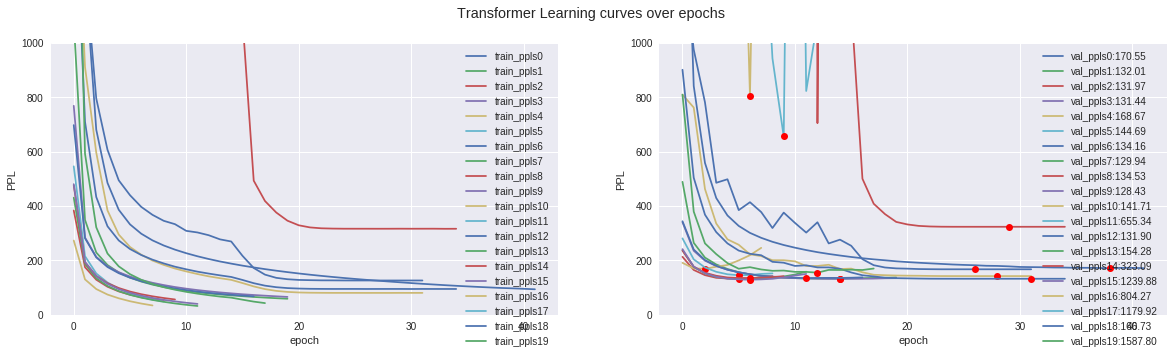

In [229]:
path=rootpath+"/4_3/Transformer/Sauvegarde results adamlrschedule"

multiplot(path, figsize=(20,5), clock_time=False, separate=False, title= 'Transformer Learning curves over epochs', print_args=True, annotate=False)

Removing or amost removing dropout has dramatically improved the overall performance in this new random search. Also, we notice that augmenting the sequence length seem to have a positive effect. Since the only limitation for transformer with this respect is the memory, we tested some additional settings and got the following final model:

Curve  0 :  TRANSFORMER ADAM 0.0005lr - 2layers1024, 64batchSize, embSize500, 1.0keepProb, 100seqLen, 4epochs


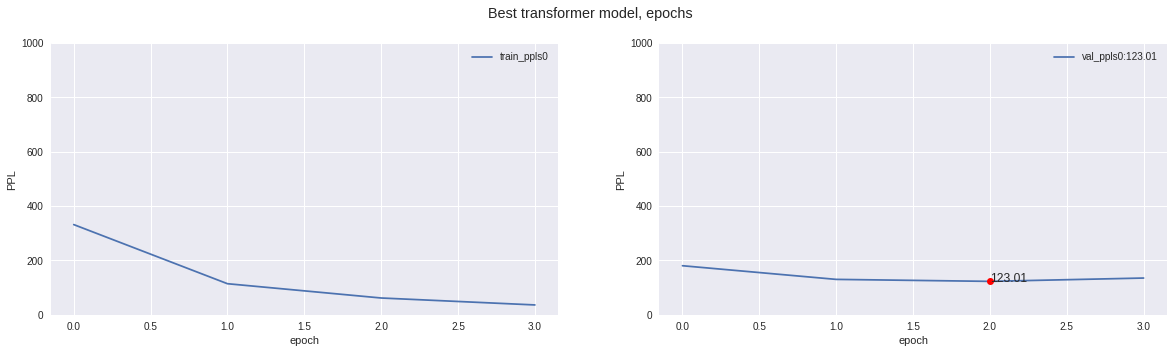

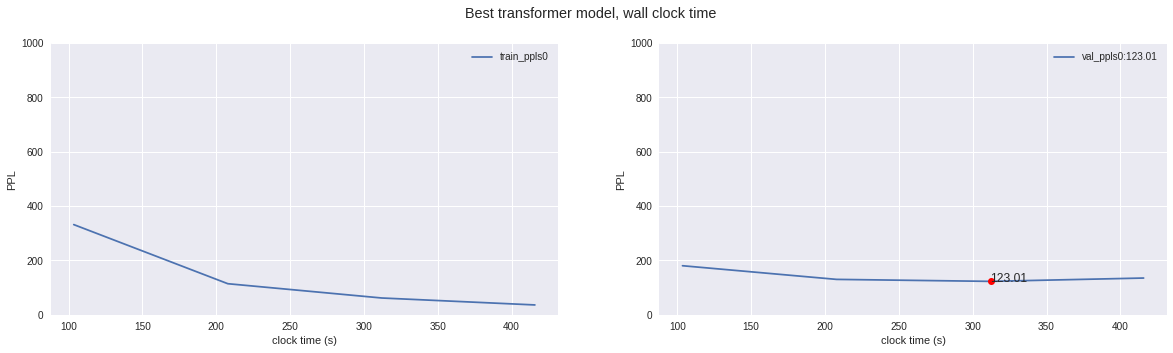

In [227]:
path=rootpath+"/4_3/Transformer/Best model ADAM ptblm"

multiplot(path, figsize=(20,5), clock_time=False, separate=False, title= 'Best transformer model, epochs', print_args=True, annotate=True)
multiplot(path, figsize=(20,5), clock_time=True, separate=False, title= 'Best transformer model, wall clock time', print_args=False, annotate=True)

Which clearly outperforms the reference transformer model of question 4.2 $(123 < 131)$.

In a nutshell, our best models hyperparameters are compered in the following table:

![Parameters](https://drive.google.com/uc?id=1A0utNUIHd13nMlM4Gjivxi0gbWdciUMq)

### Discussion <a id='4.4'></a>
___

1. In these experiments, we initially expected that the Transformer model would outperform the vanilla RNN and GRU. However, although we could perform many experiments with the Transformer and have optimized the hyperparameters as much as we could, we didn't get anywhere near the performance of the GRU (the best perplexity we were able to achieve with the Transformer is 123, whereas the reference GRU model achieves a perplexity of 103 - see table).
The Gated Recurrent Unit model has a long-short term mecanism that allows it to 'remember' previous words in the sentence for a theoretically arbitrary amount of time. Even though we were able to input very long sequences to the Transformer model, and even if the Transformer implements an attention mecanism this did not compensate for the lack of this recurrent capacity in this application.

2. As we have seen in question 4.2, the Adam and LR-schedule optimizers outperform vanilla SGD in all cases. As we have discussed, due to the inherent mecanism of Adam, the initial learning rate should be small when using this optimizer. Indeed, it must not be zero since we want to move after the first epoch, but if it is close enough to zero, the momentum mecanism will take care for optimizing the perplexity afterwards. Also, the curves plotted in question 4.2 and 4.3 clearly show that Adam is much faster to converge that the other optimizers, which might mean that the other optimizers keep overshooting in parts of the high-dimensional space.

3. If we are concerned with wall-clock time, the best architecture clearly is the Transformer with Adam optimizer. Although this sounds like a time/performance trade-off, we notice that, in general, faster convergence means better final generalization performances (i.e. better validation perplexities). This is particularly obvious with the Transformer model using Adam. However, using a model that is longer to train such as GRU leads to better generalization performance than Transformers. Indeed, Transformers are likely to overfit very quickly on the training set. This is obvious in question 4.3, where all the best Transformer models are stopped by early stopping after roughly 5 epochs.

4. The GRU seems like it is the most reliable and robust to hyperparameter changes, as questions plots from question 4.3 show. Transformer and RNN plots look indeed overally more erratic with respect to different hyperparameters, although we could not execute many GRU experiments due to the huge duration of training. This remark can be further illustrated in question 5, where we will see that the error norm shrinks more smoothly over the sequence for the GRU than for the other models.

5. We are curious to understand how these models can be adapted to continuous settings, such as signal analysis, or wavelength generation as in the WaveNet architecture. However, we don't know how to implement continuous settings for such RNNs, and this will need further exporation of the litterature. Yet, these are also seq-to-seq architectures and therefore might not differ too much from what we have implemented here.